# Timeseries analysis of Reddit sentiment data and spy prices

In this notebook I am going to analysis the correlation of the overall reddit sentiment to the SPY prices.
The SPY is the worlds largest fund and is a good benchmark on how the US markets are performing, since it tracks prices of the top 500 companies

In [2]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import numpy as np
import pandas as pd
import csv
import time
import datetime
import warnings 
warnings.filterwarnings("ignore")

In [3]:
# import data
df = pd.read_csv('/Users/ohmat/Documents/Project/reddit_stocks/data/daily_sentiment.csv', parse_dates=['date'], index_col=False)
df

,spy,date,sent
0,269.115723,2018-08-10,-9.8812
1,267.804230,2018-08-15,-17.0701
2,271.501343,2018-08-20,-0.7095
3,271.615356,2018-08-23,5.1418
4,275.407410,2018-08-27,-3.4124
...,...,...,...
481,417.940002,2021-05-10,-26.9461
482,414.209991,2021-05-11,-5.6240
483,405.410004,2021-05-12,-32.2943
484,410.279999,2021-05-13,-0.2195


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   spy     486 non-null    float64       
 1   date    486 non-null    datetime64[ns]
 2   sent    486 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 11.5 KB


In [5]:
df.describe()

,spy,sent
count,486.000000,486.000000
mean,314.837299,-3.158943
std,48.482467,14.476494
min,219.431061,-43.698100
25%,275.836182,-12.657500
50%,304.966934,-3.286300
75%,352.475662,5.691575
max,422.119995,46.818000


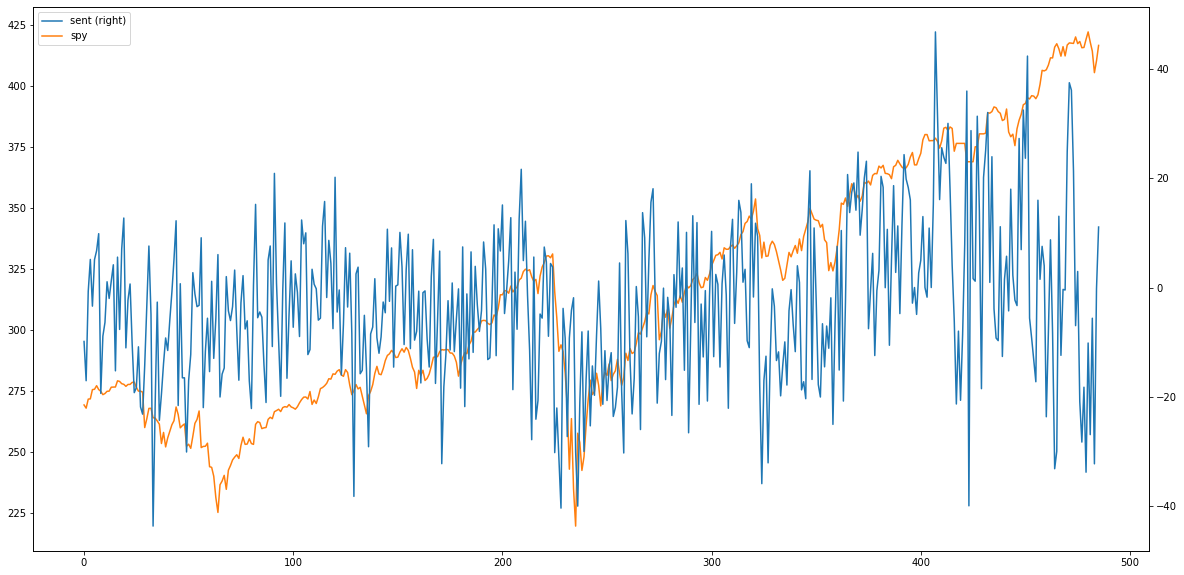

In [6]:
# plot sentiment against price
df[['sent', 'spy']].plot(secondary_y='sent', figsize=(20,10));

### Reduce noise in the sentiment score with fourier transform
To reduce noise of the sentiment score I will transform the sentiment score into the frequency spectrum, find out peaks and extreme lows, remove them, and convert it back into the time spectrum.
This will remove noise from the sentiment and smoothen the score in order to allows us to spot actual patterns in the data

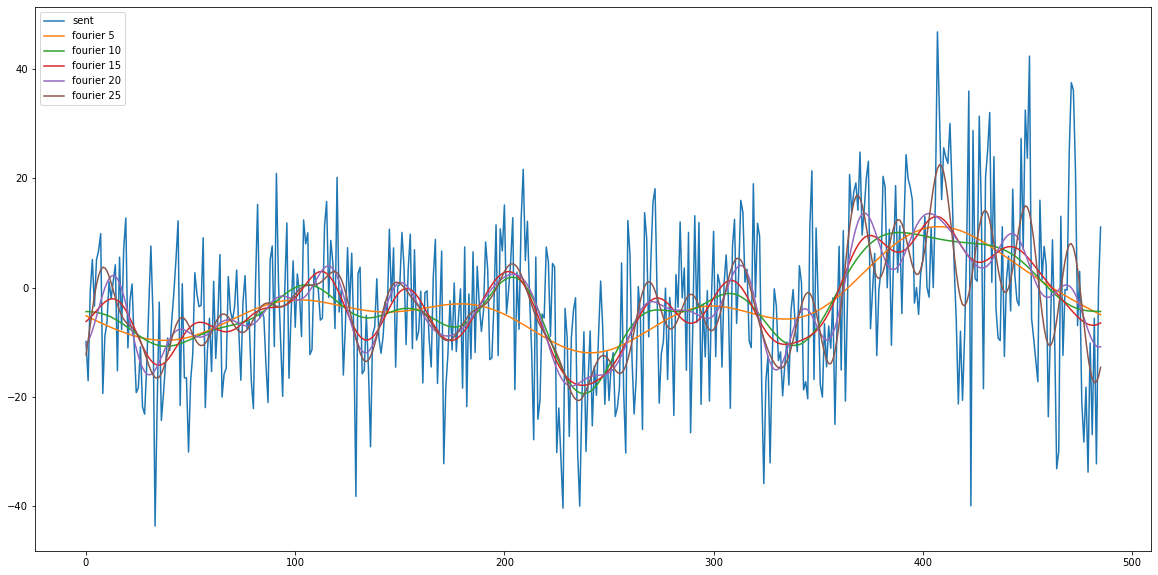

In [7]:
# extract sentiment score as a discrete fourier transform
price_fourier = np.fft.fft(np.asarray(df['sent'].tolist())) # convert sentiment to FFT with numpy
fourier_df = pd.DataFrame({'fourier':price_fourier}) # add to a dataframe
fourier_list = np.asarray(fourier_df['fourier'].tolist())  # extract fourier score as array


for num_ in range(5,30,5): # create fourier columns with scores 20 and 25
    fourier_list_m10= np.copy(fourier_list); fourier_list_m10[num_:-num_]=0 # compund fourier to smoothen signal
    # transform back into time spectrum append each fourier to dataframe with name of fourier
    df['fourier '+str(num_)]=np.fft.ifft(fourier_list_m10) 
    
# plotting sentiment score and fourier transformed scores with different compounds
df[['sent', 'fourier 5', 'fourier 10', 'fourier 15', 'fourier 20', 'fourier 25']].plot(figsize=(20, 10));


# The Fourier 25 compound appears to be the best one
I will continue my analysis with that one. First I convert the complex fourier number to a real number to make it easier to use

In [8]:
# adding an normalized number of the fourier transform:
df['sent_smooth'] = df['fourier 25'].apply(lambda x: np.real(x))
# dropping unneeded fourier transforms
df = df.drop(['fourier 5', 'fourier 10', 'fourier 15', 'fourier 20'], axis = 1)
df

,spy,date,sent,fourier 25,sent_smooth
0,269.115723,2018-08-10,-9.8812,-12.354836+0.783686j,-12.354836
1,267.804230,2018-08-15,-17.0701,-9.707922+0.404149j,-9.707922
2,271.501343,2018-08-20,-0.7095,-6.893142-0.017240j,-6.893142
3,271.615356,2018-08-23,5.1418,-4.120512-0.436845j,-4.120512
4,275.407410,2018-08-27,-3.4124,-1.582551-0.811210j,-1.582551
...,...,...,...,...,...
481,417.940002,2021-05-10,-26.9461,-16.698179+1.030670j,-16.698179
482,414.209991,2021-05-11,-5.6240,-17.434043+1.241288j,-17.434043
483,405.410004,2021-05-12,-32.2943,-17.294306+1.323361j,-17.294306
484,410.279999,2021-05-13,-0.2195,-16.322324+1.268389j,-16.322324


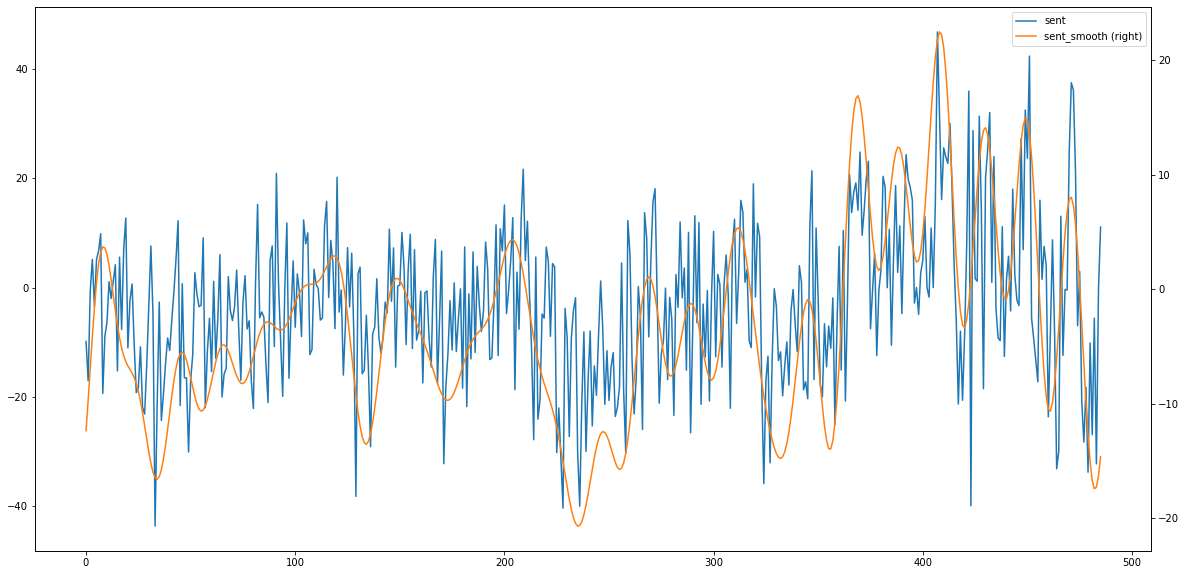

In [9]:
df[['sent', 'sent_smooth']].plot(secondary_y='sent_smooth', figsize=(20, 10));

### This worked as expected, the smoothened sentiment score looks a lot more like we can spot patterns in it
Below the smoothed score against spy price

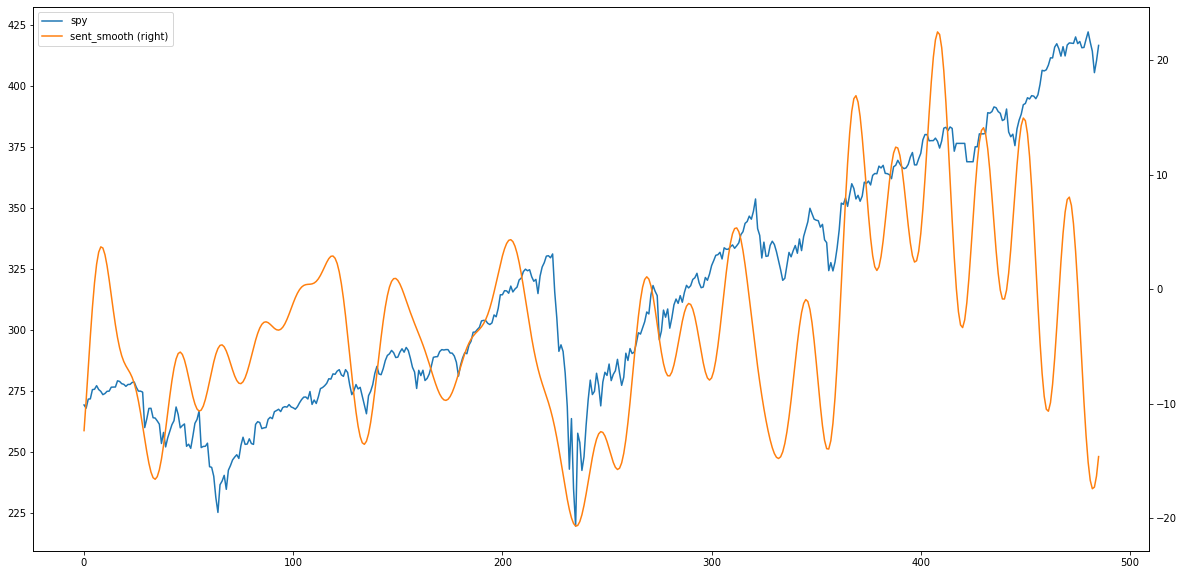

In [10]:
df[['spy', 'sent_smooth']].plot(secondary_y='sent_smooth', figsize=(20, 10));

### You can already see that there is an interesting correlation appearing here.
The appears a spread of high sentiment and prices that are starting to fall. So one interesting approach to using sentiment score for trading could be to exploit that spread. If sentiment starts going lower, but prices keep going up, you could open a short sell position. This pattern appeared most dominently tight before the corona crash, around 225 on the X axis.

Another strategy could be exploiting overextenden negative sentiment and buying whenever peopl are panicing.
This is also a common trading stragey, but has the issue that an investore seldom know the peak of panic and therefore mistimes their trades

First, let's look at seasonailty of sentiment that could be used for trading.
Afterwards I will take a look at how the spread could be exploited

### Let's see if there's similar pattern for daily returns rather than price

#### Prepare dataframe for timeseries analysis

In [11]:
# Prepare data, extracting year, month, week and weekday in seperate columns
df['year'] = [d.year for d in df.date] # year
df['month'] = [d.strftime('%b') for d in df.date] # month
df['week'] = df['date'].dt.week # week number
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'} # prepare weekday
df['weekday'] = df['date'].dt.dayofweek.map(dayOfWeek) # create weekday
years = df['year'].unique() # fill in years
# create return column for spy prices
df['return %']= ((df['spy'][:-1].values / df['spy'][1:] - 1) *100) # caluclate daily returns
df.head(2)

,spy,date,sent,fourier 25,sent_smooth,year,month,week,weekday,return %
0,269.115723,2018-08-10,-9.8812,-12.354836+0.783686j,-12.354836,2018,Aug,32,Friday,NaN
1,267.804230,2018-08-15,-17.0701,-9.707922+0.404149j,-9.707922,2018,Aug,33,Wednesday,0.489721


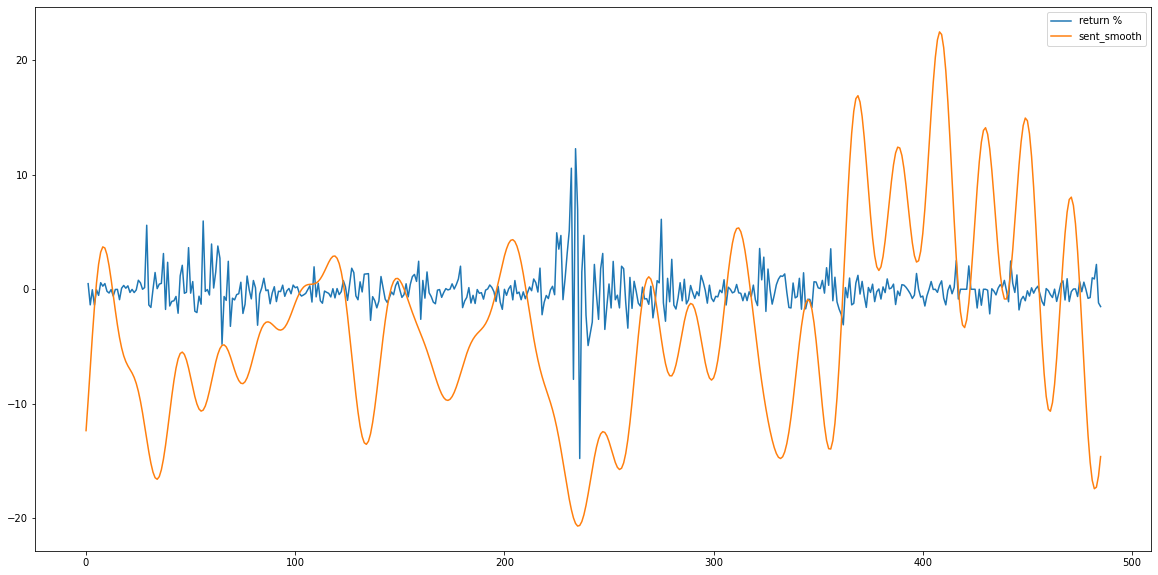

In [12]:
df[['return %', 'sent_smooth', ]].plot(secondary_y='sent_norm', figsize=(20, 10));

### There is no visible correlation between the daily returns and the sentiment of reddit, except when sharp movements in returns occur
#### Next I will plot sentiment score over the year, but each year seperated
***

In [13]:
# Generate random colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

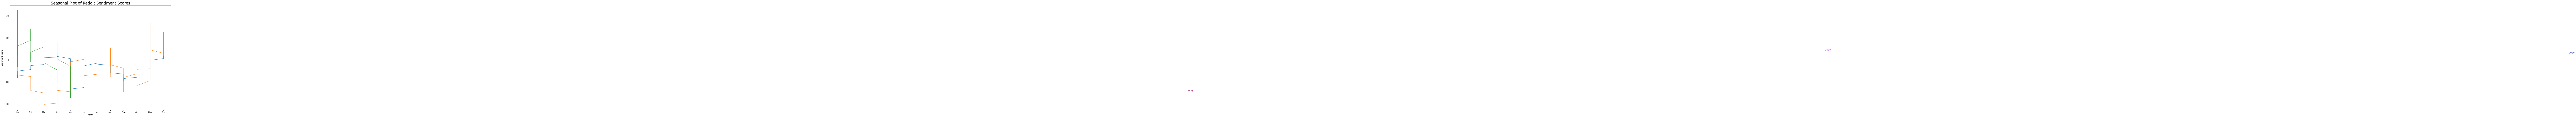

In [14]:
# Draw Plot
plt.figure(figsize=(15,10), dpi=80)

for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'sent_smooth',data=df.loc[df.year==y, :], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'sent_smooth'][-1:].values[0], y, fontsize=12, color=mycolors[i])
        
plt.gca().set(ylabel='Sentiment Score', xlabel='Month')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Reddit Sentiment Scores", fontsize=20)
plt.show()        

### The highest sentiment score generally appear in the end and the beginning of the year. 
A sharp decline happens in the summer months of june and july. This matches the general market behaviour, most professional traders and retail investors are on vacation some time over the summer, while bonusses get often paid out around the end of the year, leading to more people that invest

### Boxplot of seasonal sentiment score distribution

# Draw Plot

Below I will draw plots that aggregate the sentiment score on a yearly, monthly, weekly and weekday basis and see if I can spot pattern

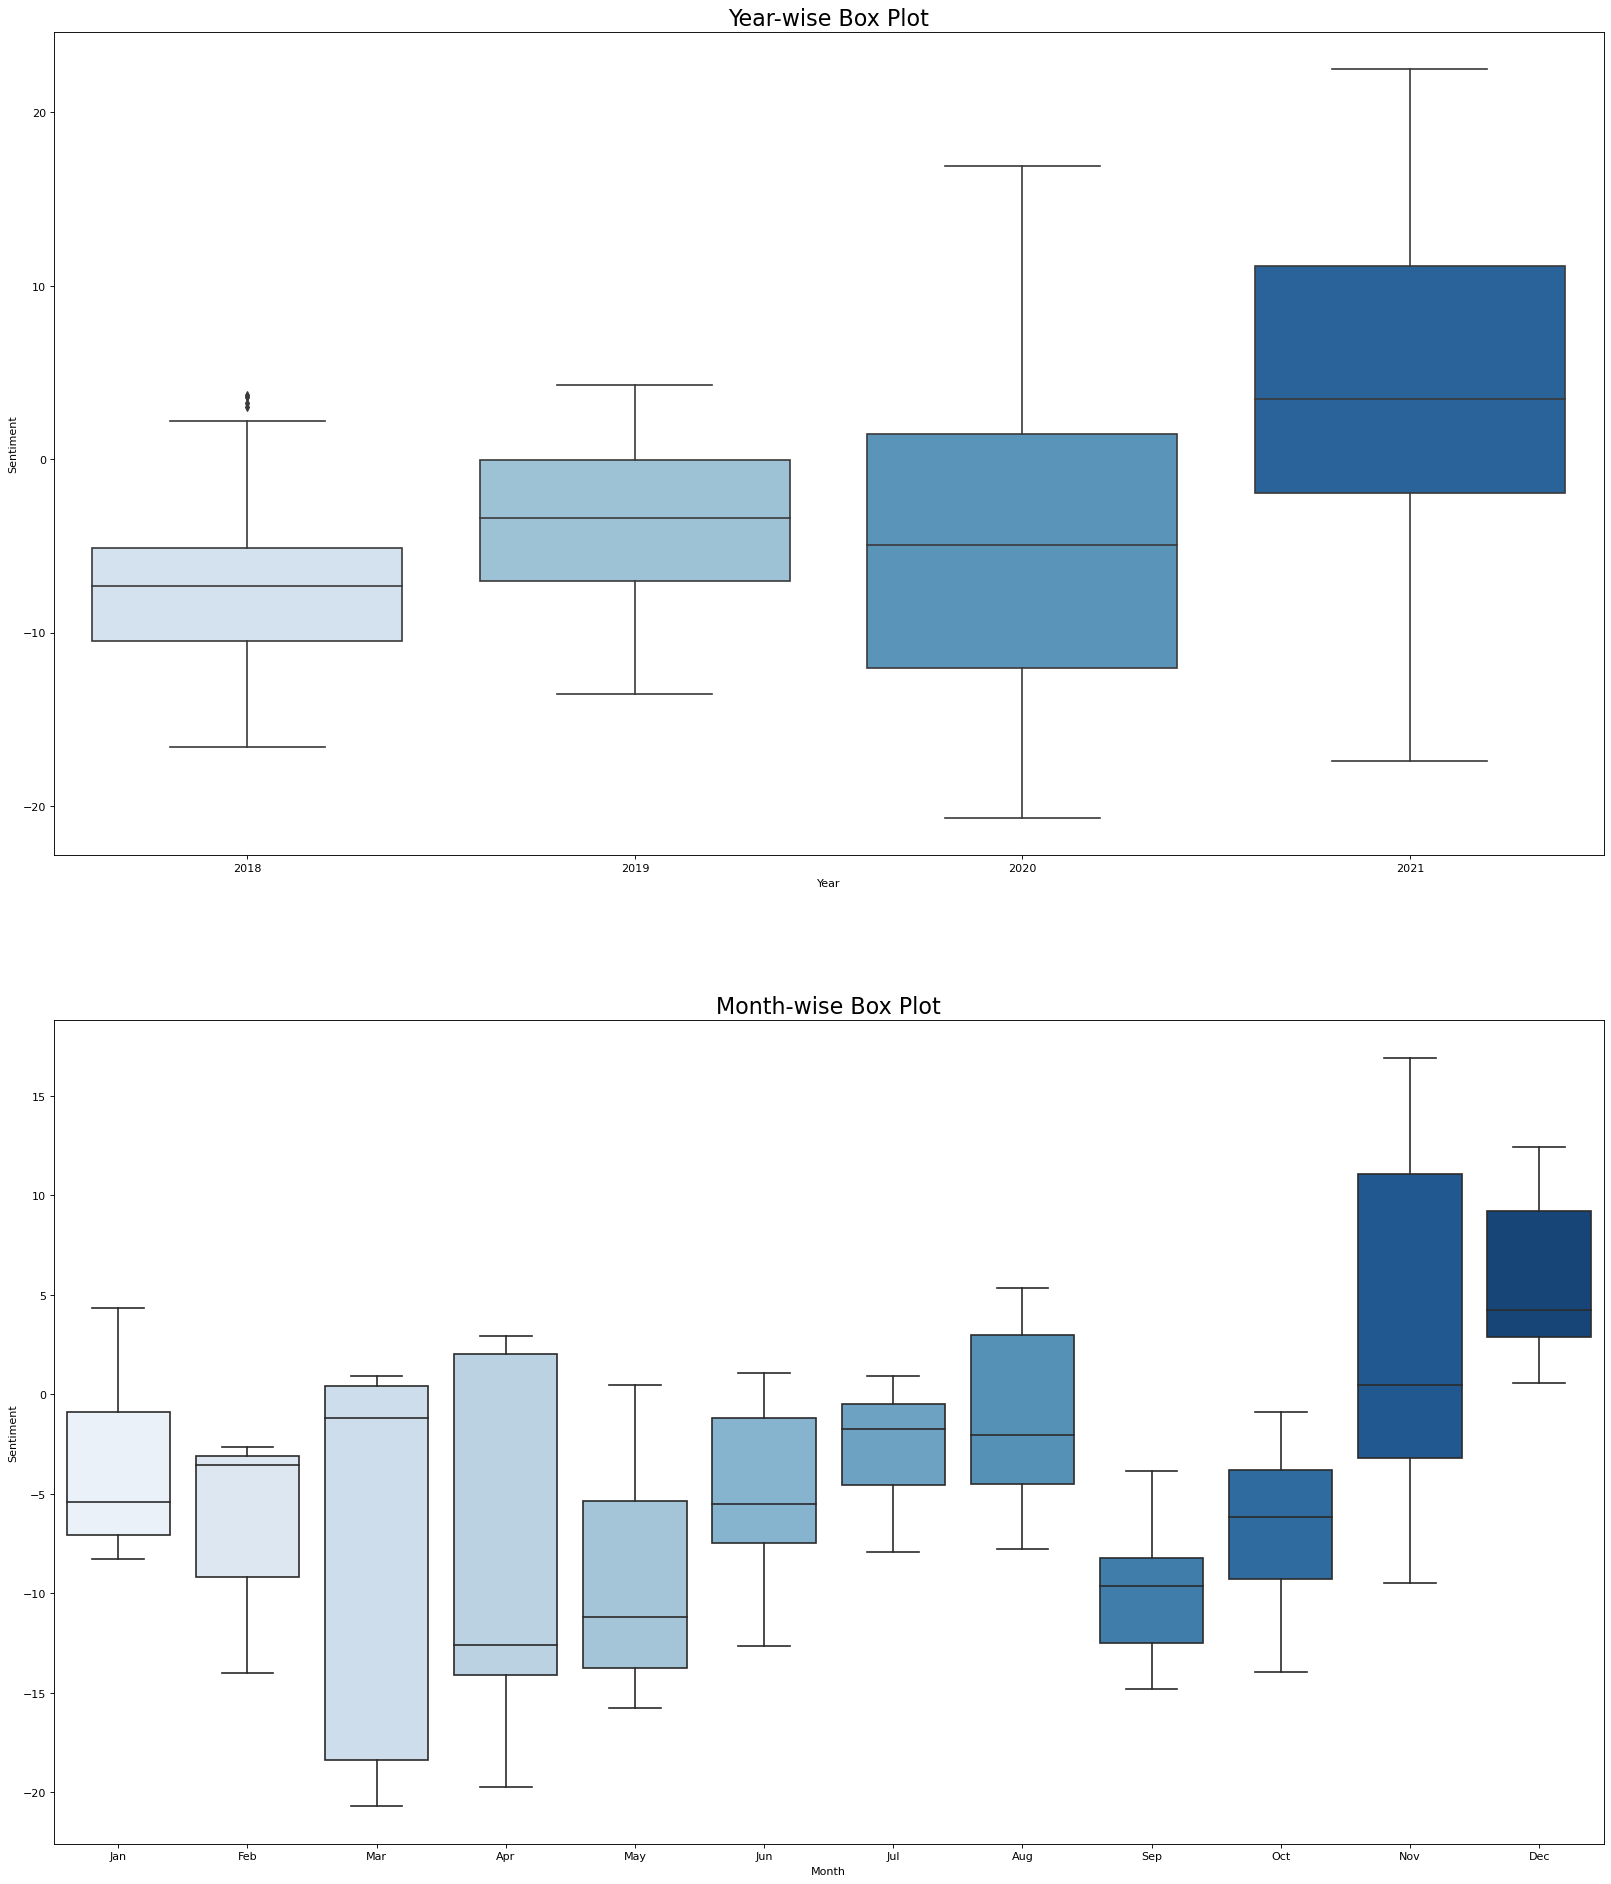

In [15]:
# Draw yearly and monthtly plots

fig, axes = plt.subplots(2, 1, figsize=(25,30), dpi= 80)

sn.boxplot(x='year', y='sent_smooth',palette="Blues",data=df, ax=axes[0]);
sn.boxplot(x='month', y='sent_smooth', palette="Blues", data=df.loc[~df.year.isin([2018, 2021]), :]);

# Set Titles
plt.rcParams["axes.labelsize"] = 20
axes[0].set_title('Year-wise Box Plot', fontsize=20); 
axes[1].set_title('Month-wise Box Plot', fontsize=20);
axes[0].set(xlabel='Year', ylabel='Sentiment')
axes[1].set(xlabel='Month', ylabel='Sentiment')

plt.show();

## Trends visibile in yearly and monthly plots:
* Over the course of the years, sentiment increased. This is likely due to more market participants enterin in the timeframe 2019-2021
* The highest sentiment frequently appears at the end of the year. This could be due to yearly bonuses getting paid out in November/December.
* There's seasonal drop appearing in september, when the summer ends. It is also wll known under traders that september is usually the month with the lowest returns, since the summer ends, and most market participants are prepareing for the year end rallys

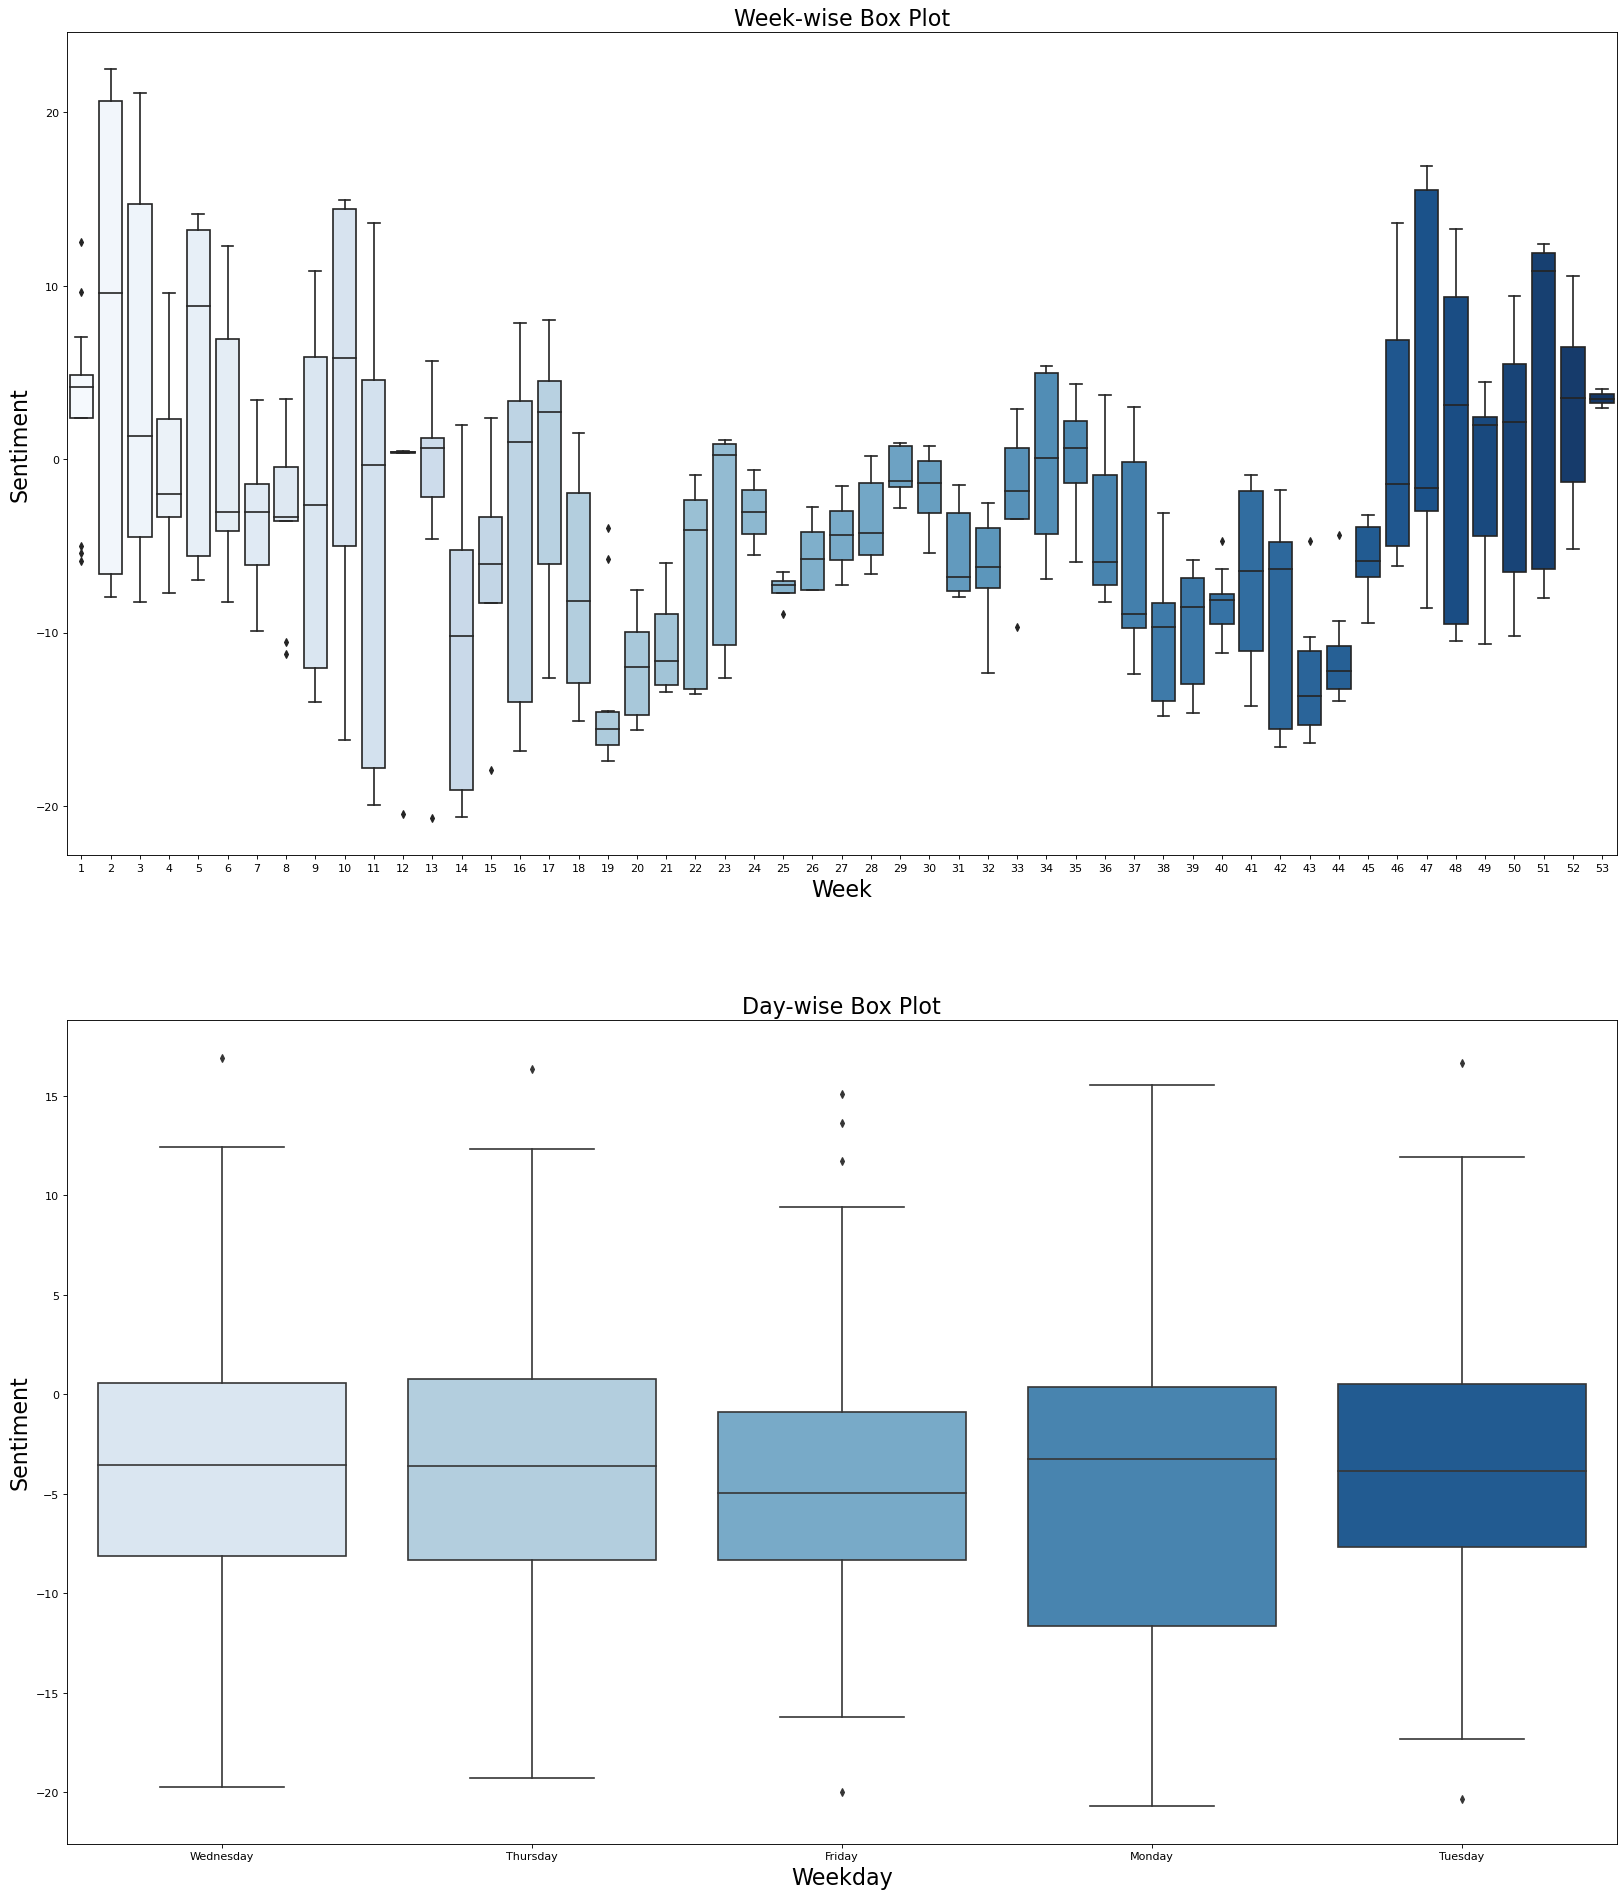

In [16]:
#Draw weekly and weekday plota

fig, axes = plt.subplots(2, 1, figsize=(25,30), dpi= 80)

sn.boxplot(x='week', y='sent_smooth',palette="Blues",data=df, ax=axes[0]);
sn.boxplot(x='weekday', y='sent_smooth', palette="Blues", data=df.loc[~df.year.isin([2018, 2021]), :]);

# Set Titles
plt.rcParams["axes.labelsize"] = 20
axes[0].set_title('Week-wise Box Plot', fontsize=20); 
axes[1].set_title('Day-wise Box Plot', fontsize=20);
axes[0].set(xlabel='Week', ylabel='Sentiment')
axes[1].set(xlabel='Weekday', ylabel='Sentiment')

plt.show();

## Trends visibile in weekly and weekday plots:
* Sentimnent varies a lot on individual weekdays. There seems to be no trends in weekdays, so buying every monday and selling every friday doesn't make sense according to the data
* On the weekly level we can clearly see that there is two seasonal drops in sentiment happening: One around week 14 in the beginning of April, and another one around week 38-43, which is mid September until mid of October

### Creating the same plots for returns to see if the seasonality is also visible in returns

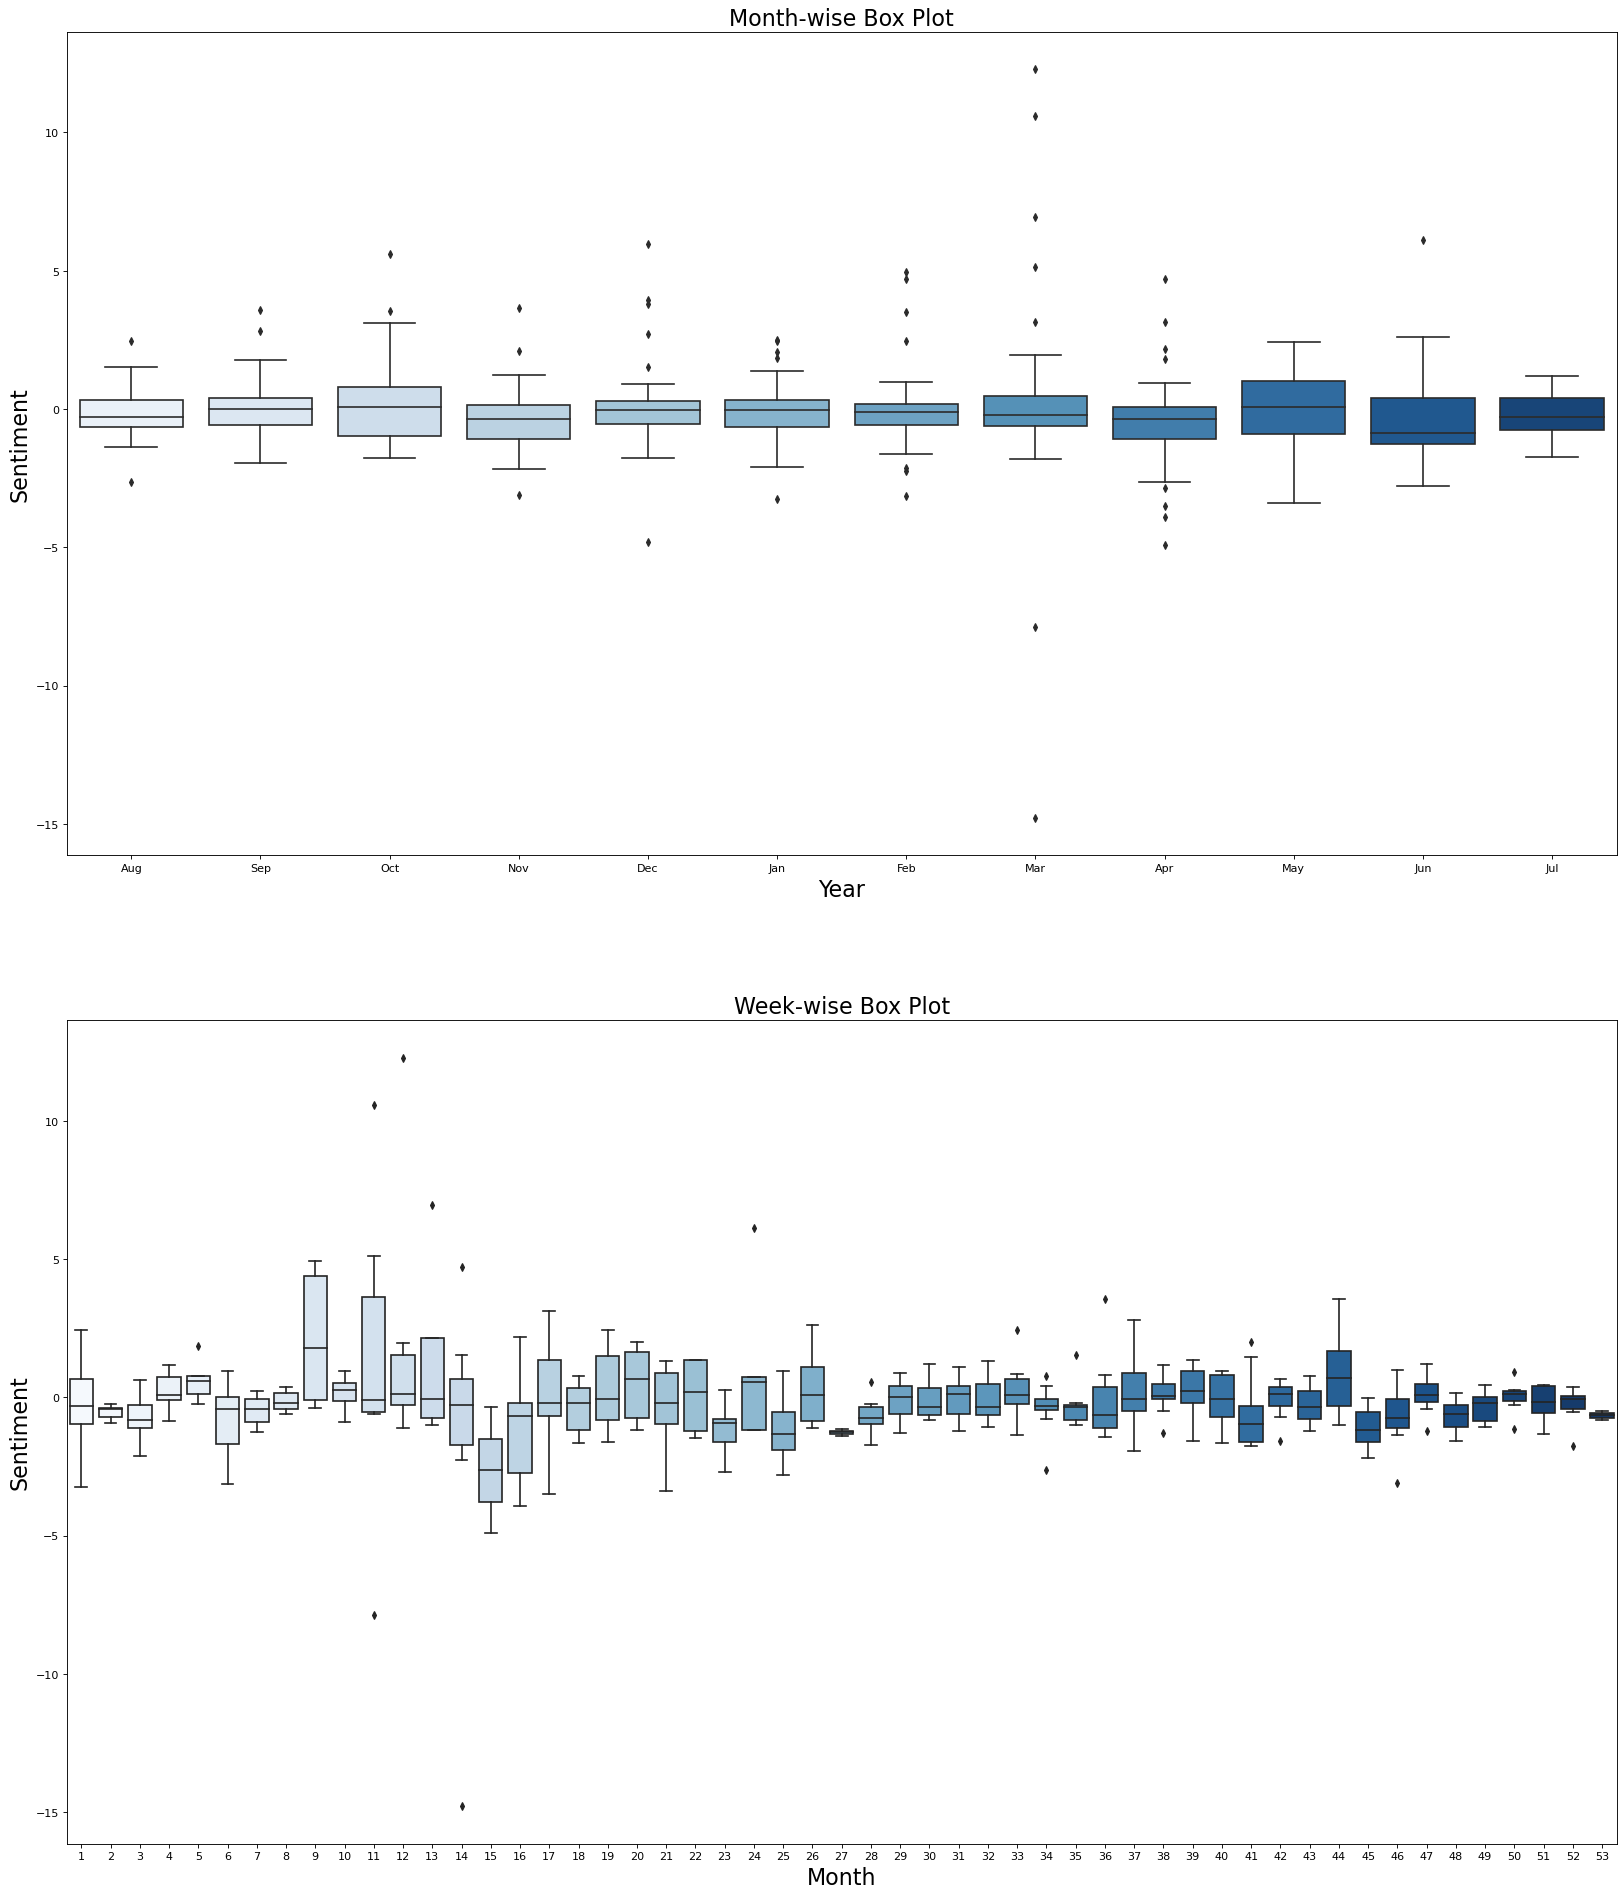

In [17]:
## Now doing the same for price returns
# Draw yearly and monthtly plots

fig, axes = plt.subplots(2, 1, figsize=(25,30), dpi= 80)

sn.boxplot(x='month', y='return %',palette="Blues",data=df, ax=axes[0]);
sn.boxplot(x='week', y='return %', palette="Blues", data=df.loc[~df.year.isin([2018, 2021]), :]);

# Set Titles
plt.rcParams["axes.labelsize"] = 20
axes[0].set_title('Month-wise Box Plot', fontsize=20); 
axes[1].set_title('Week-wise Box Plot', fontsize=20);
axes[0].set(xlabel='Year', ylabel='Sentiment')
axes[1].set(xlabel='Month', ylabel='Sentiment')

plt.show();

***